In [1]:
import os
import sys
import datetime 
import numpy as np
import math
sys.path.append("..")
# from tqdm.rich import tqdm, trange
from tqdm import tqdm, trange
from copy import deepcopy
import h5py
import pandas as pd 

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchmetrics.regression import MeanAbsolutePercentageError

import seaborn as sns
import matplotlib.pylab as plt

from data_loader import get_database_path, get_h5_files, read_h5_file



In [2]:
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Set default tensor type
if sys.platform == "darwin":
    # Mac OS
    default_precision = torch.float32
else:
    # Linux or Windows
    default_precision = torch.float64
torch.set_default_dtype(default_precision)

# Set device
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
print(f"Using {device} device")

Using cuda device


# Load dataset

In [3]:
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()


# SM processes
bkg = read_h5_file(database_path, bkg_files[0]['file'])
bkg_pairs, bkg_emds = read_h5_file(database_path, "bkg_emds.h5", datatype='EMD')

In [4]:
class PairedEventsDataset(Dataset):
    def __init__(self, events, pairs, emds):
        assert len(emds) == len(pairs)
        assert len(pairs.shape) == 2 and pairs.shape[1] == 2
        self.events = torch.from_numpy(events[:, :, :3])
        self.pairs = torch.from_numpy(pairs)
        self.emds = torch.from_numpy(emds)
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.events[self.pairs[idx][0]], self.events[self.pairs[idx][1]], self.emds[idx]

In [5]:
print(len(bkg), len(bkg_pairs), len(bkg_emds))
train_val_split = 0.8
train_size = int(len(bkg_pairs) * train_val_split)
print(train_size)

13451915 67259575 67259575
53807660


In [6]:
train_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[:train_size], bkg_emds[:train_size])
val_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[train_size:], bkg_emds[train_size:])

In [7]:
selected_train = 20000
selected_val = 10000
train_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[:selected_train], bkg_emds[:selected_train])
val_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[-selected_val:], bkg_emds[-selected_val:])
print(len(train_bkg_dataset), len(val_bkg_dataset))

20000 10000


In [8]:
train_bkg_dataloader = DataLoader(train_bkg_dataset, batch_size=256, shuffle=True, num_workers=16, prefetch_factor=5)
val_bkg_dataloader = DataLoader(val_bkg_dataset, batch_size=256, shuffle=True, num_workers=16, prefetch_factor=5)

# Model

In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        def make_layer(in_size, out_size):
            return nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.LeakyReLU(),
                nn.Dropout(0.1)
            )
        self.layers = nn.Sequential(
            make_layer(input_size, hidden_sizes[0]),
            *[make_layer(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)],
            nn.Linear(hidden_sizes[-1], output_size)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

In [60]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('encoding', encoding.unsqueeze(0).transpose(0, 1))


    def forward(self, x):
        return x + self.encoding[:x.size(0), :]

    
    
class ParticleEventTransformer(nn.Module):
    def __init__(self, feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers):
        super(ParticleEventTransformer, self).__init__()
        self.particle_embedding = nn.Linear(feature_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)
        encoder_layers = TransformerEncoderLayer(embed_size, num_heads, hidden_dim)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.output_layer = nn.Linear(embed_size * 19, output_dim)
        self.embed_size = embed_size
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.particle_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.particle_embedding(x)  # [batch_size, 19, embed_size]
        x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch_size, embedding_dim]
        x = self.pos_encoder(x * math.sqrt(self.embed_size))
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Switch back to [batch_size, seq_len, embedding_dim]
        x = x.reshape(x.shape[0], -1)  # Flatten
        x = self.output_layer(x)
        return x
    

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)


    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class particleTransformer(nn.Module):
    def __init__(self, particle_feature_size, d_model, nhead, num_encoder_layers, embed_dim, max_seq_length, pos_dropout, layer_widths):
        super().__init__()  
        self.d_model = d_model
        self.embed_src = nn.Linear(particle_feature_size, d_model)
        self.embed_tgt = nn.Linear(particle_feature_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        #self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.NPART = max_seq_length

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat,out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(num_features=out_feat))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(p=0.5, inplace = False))
            return layers


        #layer_widths = [200,50,10]
        self.fcblock = nn.Sequential(
                                     *block(d_model*max_seq_length, layer_widths[0] ),
                                     *[layers for i in range(len(layer_widths)-1) for layers in block(layer_widths[i],layer_widths[i+1])],
                                     nn.Linear(layer_widths[-1], embed_dim)
                                     )
        #print(self.fcblock)


    def forward(self, src):

        src = src.permute(1,0,2)
        #tgt = tgt.permute(1,0,2)

        #src = self.embed_src(src)
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model))
        #tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        #output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
        #                          tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = self.transformer_encoder(src)
        output = output.permute(1,0,2)
        output = output.reshape(-1,self.d_model*self.NPART)
        #print(self.fcblock)
        output = self.fcblock(output)
        return output

# Loss & Metric

In [25]:
def Euclidean_distance(y1, y2):
    return torch.norm(y1 - y2, dim=1)

def hyperbolic_distance(y1, y2):
    return torch.acosh(1 + 2 * torch.sum((y1 - y2)**2, dim=1) / ((1 - torch.sum(y1**2, dim=1)) * (1 - torch.sum(y2**2, dim=1))))

In [26]:
a = torch.randn(10, 3)
b = torch.randn(10, 3)
print(Euclidean_distance(a, b).shape)
print(hyperbolic_distance(a, b).shape)

torch.Size([10])
torch.Size([10])


In [27]:
MAPE = MeanAbsolutePercentageError().to(device)

def MAPE_dispersion(original_distance, embed_distance):
        dispersion_emd = torch.var(original_distance, dim=0) / torch.mean(original_distance, dim=0)
        dispersion_ori = torch.var(embed_distance, dim=0) / torch.mean(embed_distance, dim=0)
        return MAPE(dispersion_emd, dispersion_ori)

def embed_ratio(embed_distance, original_distance):
    return torch.mean(embed_distance / original_distance)


In [28]:
class MetricUpdater(nn.Module):
    def __init__(self, metric_fn):
        super(MetricUpdater, self).__init__()
        self.metric_fn = metric_fn
        self.total_metric = 0
        self.count = 0
    def forward(self, original, embed):
        metric = self.metric_fn(embed, original)
        self.update(metric)
        return metric
    def update(self, metric):
        self.total_metric += metric
        self.count += 1
    def compute(self):
        return self.total_metric / self.count
    def reset(self):
        self.total_metric = 0
        self.count = 0

In [34]:
MAPE_updater = MetricUpdater(MAPE)
MAPE_dispersion_updater = MetricUpdater(MAPE_dispersion)
embed_ratio_updater = MetricUpdater(embed_ratio)


In [35]:
metric_dict = {"MAPE": MAPE_updater, "Var of MAPE": MAPE_dispersion_updater, "Embed Ratio": embed_ratio_updater}

# Train Pipeline

In [61]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn, dist_fn,
                 stage = "train", metrics_dict = None, 
                 optimizer = None
                 ):
        self.model,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer = optimizer
        self.dist_fn = dist_fn
            
    def step(self, source_event, target_event, emd):
        # forward
        source_event, target_event, emd = source_event.to(device), target_event.to(device), emd.to(device)
        source_emebedding = self.model(source_event)
        target_embedding = self.model(target_event)
        emb_distance = self.dist_fn(source_emebedding, target_embedding)
        # loss
        loss = self.loss_fn(emb_distance, emd)
        
        # backward
        if self.optimizer is not None and self.stage=="train": 
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        # metrics
        step_metrics = {self.stage+"_"+name:(metric_fn(emb_distance, emd)).item()
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(), step_metrics
    
    def train_step(self, source_event, target_event, emd):
        self.model.train() 
        return self.step(source_event, target_event, emd)
    
    @torch.no_grad()
    def eval_step(self, source_event, target_event, emd):
        self.model.eval() 
        return self.step(source_event, target_event, emd)
    
    def __call__(self, source_event, target_event, emd):
        if self.stage=="train":
            return self.train_step(source_event, target_event, emd) 
        else:
            return self.eval_step(source_event, target_event, emd)
        
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader), file = sys.stdout)
        for batch_idx, (source_event, target_event, emd) in loop: 
            loss, step_metrics = self.steprunner(source_event, target_event, emd)
            step_log = dict({self.stage+"_loss":loss},**step_metrics)
            total_loss += loss
            step+=1
            if batch_idx!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item()
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log

# @torch.compile()
def train_model(net, optimizer, 
                loss_fn, dist_fn,
                metrics_dict, 
                train_dataloader, val_dataloader=None, 
                epochs=10, ckpt_path='checkpoint.pt',
                patience=5, monitor="train_MAPE", mode="min"):
    
    history = {}

    for epoch in range(1, epochs+1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1，train -------------------------------------------------  
        train_step_runner = StepRunner(net = net,stage="train", dist_fn=dist_fn,
                loss_fn = loss_fn,metrics_dict=metrics_dict,
                optimizer = optimizer)
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_dataloader)

        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2，validate -------------------------------------------------
        if val_dataloader:
            val_step_runner = StepRunner(net = net,stage="val",
                loss_fn = loss_fn, dist_fn=dist_fn,metrics_dict=metrics_dict)
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_dataloader)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

        # 3，early-stopping -------------------------------------------------
            arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
        if best_score_idx==len(arr_scores)-1:
            torch.save(net.state_dict(),ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                 arr_scores[best_score_idx]))
        if len(arr_scores)-best_score_idx>patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                monitor,patience))
            break 
    net.load_state_dict(torch.load(ckpt_path))
    return pd.DataFrame(history)

# Train!

In [69]:
feature_size = 3  # pT, eta, phi
embed_size = 16  # Dimension of embedding space
num_heads = 4    # Number of attention heads
hidden_dim = 256 # Dimension of the feedforward network model in nn.TransformerEncoder
output_dim = 10  # Final dimension of the output embedding
num_layers = 4   # Number of nn.TransformerEncoderLayer

model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)
# model = particleTransformer(feature_size, d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers, embed_dim=output_dim, max_seq_length=19, pos_dropout=0.1, layer_widths=[200,50,10])

model.to(device)
loss_fn = MAPE
dist_fn = Euclidean_distance
# dist_fn = hyperbolic_distance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [70]:
dfhistory = train_model(model, optimizer, 
                        loss_fn, dist_fn, metric_dict, 
                        train_dataloader=train_bkg_dataloader, val_dataloader=val_bkg_dataloader,
                        monitor="val_MAPE", mode="min",
                        epochs=50)


================================================================================2024-04-28 23:10:54
Epoch 1 / 50

100%|██████████| 40/40 [00:00<00:00, 82.08it/s, val_Embed Ratio=10.3, val_MAPE=9.33, val_Var of MAPE=3.86, val_loss=0.853]
<<<<<< reach best val_MAPE : 9.329274593646984 >>>>>>

================================================================================2024-04-28 23:10:58
Epoch 2 / 50

100%|██████████| 40/40 [00:00<00:00, 82.12it/s, val_Embed Ratio=10.7, val_MAPE=9.68, val_Var of MAPE=4.5, val_loss=0.859] 

================================================================================2024-04-28 23:11:02
Epoch 3 / 50

100%|██████████| 40/40 [00:00<00:00, 82.80it/s, val_Embed Ratio=11.2, val_MAPE=10.2, val_Var of MAPE=4.67, val_loss=0.868]

================================================================================2024-04-28 23:11:06
Epoch 4 / 50

100%|██████████| 40/40 [00:00<00:00, 81.35it/s, val_Embed Ratio=8.95, val_MAPE=7.95, val_Var of MAPE=2.4, val_loss=0.

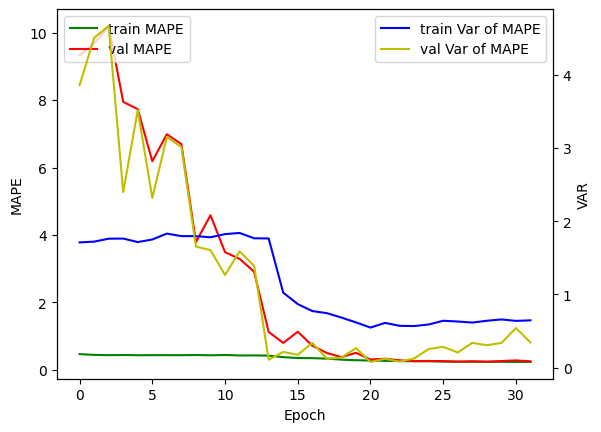

In [71]:
x = np.arange(len(dfhistory["train_loss"]))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, dfhistory["train_MAPE"], 'g-', label="train MAPE")
ax1.plot(x, dfhistory["val_MAPE"], 'r-', label="val MAPE")
ax1.legend(loc="upper left")
ax2.plot(x, dfhistory["train_Var of MAPE"], 'b-', label="train Var of MAPE")
ax2.plot(x, dfhistory["val_Var of MAPE"], 'y-', label="val Var of MAPE")
ax2.legend(loc="upper right")
# ax1.set_yscale('log')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAPE')
ax2.set_ylabel('VAR')

plt.show()